In [40]:
seed = 0

In [41]:
from utilities.load_data import load_fullECAI
from utilities.evaluation import *
from utilities.evaluation import _my_scorer

In [42]:
import os
import joblib

import numpy as np
import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer

import shap

In [43]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [44]:
grid_name = 'GridSearchCV_22-03-22_03-27-03'
grid = joblib.load('./results/XGBoost/{}/{}.pkl'.format(grid_name, grid_name))

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [52]:
model_path = './results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best_xgb.pkl'
#model_path = './results/Basic/models/RandomForestClassifier.pkl'
#model_path = './results/Basic/models/LogisticRegression.pkl'
#model_path = './results/Basic/models/LinearDiscriminantAnalysis.pkl'
#model_path = './results/Basic/models/XGBClassifier.pkl'


model_results = joblib.load(model_path)
shap_df = model_results['shap']

## Graph representation

In [46]:
from igraph import Graph
import igraph as ig
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
%%time
shap_dist = euclidean_distances(shap_df)
# Scale distances 0 - 1
#normalized_dist = MinMaxScaler().fit_transform(shap_dist)
#n = normalized_dist.shape[0]

CPU times: total: 656 ms
Wall time: 162 ms


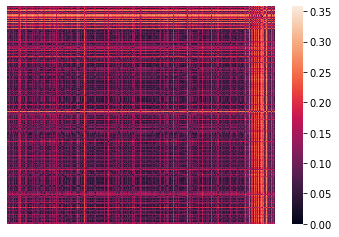

In [33]:
ax = sns.heatmap(shap_dist[np.argsort(y_test).values][:,np.argsort(y_test).values], xticklabels=False, yticklabels=False)
ax.invert_yaxis()
if not os.path.exists('./results/XGBoost/{}/figures/Best'.format(grid_name)):
    os.makedirs('./results/XGBoost/{}/figures/Best'.format(grid_name))
plt.savefig('./results/XGBoost/{}/figures/Best/adjmatrix.png'.format(grid_name), bbox_inches='tight', dpi=300, transparent=True)

In [54]:
shap_df, _, y_test1, _= train_test_split(shap_df, y_test, train_size=100)
shap_dist = euclidean_distances(shap_df)

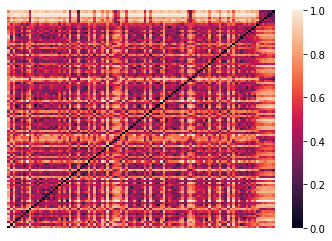

In [55]:
normalized_dist = MinMaxScaler().fit_transform(shap_dist)
ax = sns.heatmap(normalized_dist[np.argsort(y_test1).values][:,np.argsort(y_test1).values], xticklabels=False, yticklabels=False)
ax.invert_yaxis()

In [56]:
shap_df.shape

(100, 19)

# Reduce Dimension

## Criteria: Efficiency

In [50]:
%%time
def nodal_eff(g):
    """
    Finds local nodal efficiency
    
    Source: https://stackoverflow.com/questions/56609704/how-do-i-calculate-the-global-efficiency-of-graph-in-igraph-python
    
    Parameters
    --------
    g : igraph.Graph
        Weighted Graph
    
    Returns
    --------
    ne : float
        Nodal efficiency
    
    Examples
    --------
    # Local efficiency
    >>> eff = nodal_eff(g)
    # Global efficiency
    >>> global_eff = mean(eff)
    """

    
    weights = g.es["weight"][:]
    sp = (1.0 / np.array(g.shortest_paths_dijkstra(weights=weights)))
    np.fill_diagonal(sp,0)
    N=sp.shape[0]
    ne= (1.0/(N-1)) * np.apply_along_axis(sum,0,sp)

    return ne

def plot_eff_by_cutoff():
    """
    Plots global (mean) efficienty of network by cutting edges that are too far
    """
    # Estimated time with full graph: 2-3hrs
    cutoffs = np.array(range(1,11))/10
    effs = []
    optimal_G = None
    optimal_eff = 0 # Change to infinity
    optimal_cutoff = None
    for co in cutoffs:
        # Remove edges between too far vertices
        adj_matrix = normalized_dist.copy()
        too_far = adj_matrix > co
        adj_matrix = adj_matrix.astype(object) 
        adj_matrix[too_far] = None
        reduced_G = Graph.Weighted_Adjacency(adj_matrix, mode='undirected', loops=False)
        print('cutoff: {}, aristas: {}'.format(co, len(list(reduced_G.es))))
        eff = nodal_eff(reduced_G)
        mean_eff = np.mean(eff)
        
        if mean_eff > optimal_eff:
            optimal_G = reduced_G
            optimal_eff = mean_eff
            optimal_cutoff = co
            optimal_adj = adj_matrix
        effs.append(mean_eff)
    
    optimals = (optimal_G, optimal_eff, optimal_cutoff, optimal_adj)
    
    plt.plot(cutoffs, effs)
    return effs, optimals

## Devolver el max_id y la matriz en la que se maximiza. Devolver cuántos se cortaron. Early stopping cuando disminuya.
## Checar numero de aristas, que tome la matriz como simétrica
## Contar G.es de entrada y de salida
## Parar al 80%
## aplicar a la red completa
## Layout circulo

CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
effs

[0.04706741907044775,
 0.9808773851564512,
 1.80655587027761,
 1.9963694287529483,
 2.097715874925347,
 2.121431021564085,
 2.1288690131648456,
 2.1153085918299364,
 2.0967907181456726,
 2.0849557055039165]

non-numeric value in matrix ignored
divide by zero encountered in true_divide


cutoff: 0.1, aristas: 7
cutoff: 0.2, aristas: 107
cutoff: 0.3, aristas: 569
cutoff: 0.4, aristas: 1468
cutoff: 0.5, aristas: 2492
cutoff: 0.6, aristas: 3300
cutoff: 0.7, aristas: 4034
cutoff: 0.8, aristas: 4678
cutoff: 0.9, aristas: 4906
cutoff: 1.0, aristas: 4950
CPU times: total: 188 ms
Wall time: 180 ms


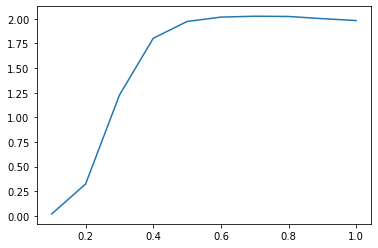

In [57]:
%%time
effs, optimals = plot_eff_by_cutoff()

In [58]:
optimal_G, optimal_eff, optimal_cutoff, optimal_adj = optimals

In [60]:
optimal_cutoff

0.7

In [36]:
len(list(optimal_G.es))

346198

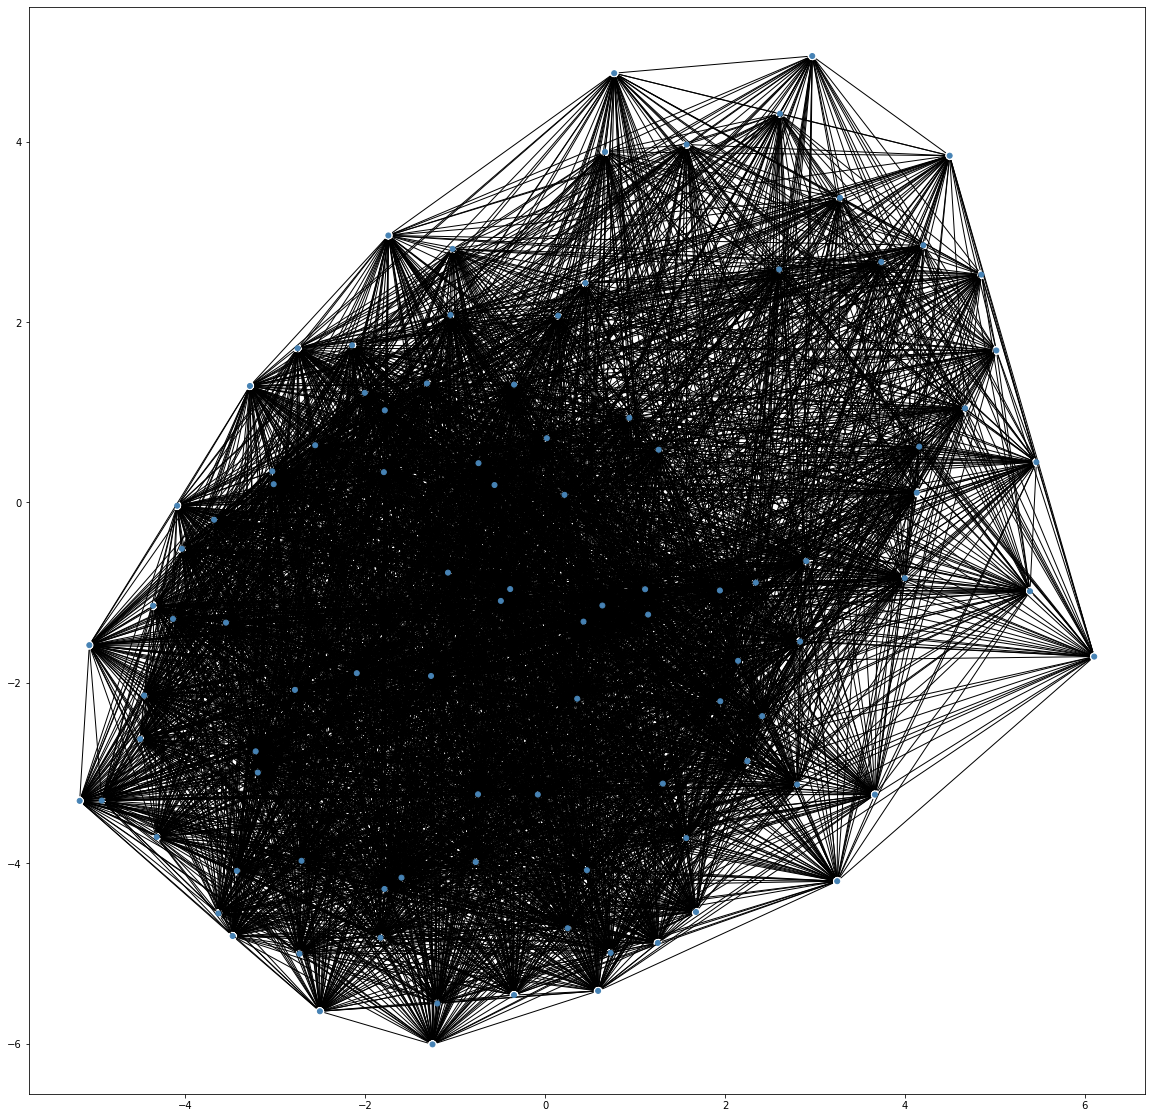

In [59]:
fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(optimal_G, target=ax)